In [1]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

import warnings

pd.set_option('display.max_rows',20)
matplotlib.rcParams['figure.figsize'] = (10,8)
warnings.filterwarnings('ignore')

matplotlib.style.use('ggplot') # Look Pretty
# If the above line throws an error, use plt.style.use('ggplot') instead

In [2]:
df = pd.read_csv('LoansTrainingSetV2.csv')
print 'Size of the data is: {} rows and {} columns'.format(df.shape[0],df.shape[1])
print 'Features in the data set are:\n %s'%(df.columns)

Size of the data is: 111107 rows and 19 columns
Features in the data set are:
 Index([u'Loan ID', u'Customer ID', u'Loan Status', u'Current Loan Amount',
       u'Term', u'Credit Score', u'Years in current job', u'Home Ownership',
       u'Annual Income', u'Purpose', u'Monthly Debt',
       u'Years of Credit History', u'Months since last delinquent',
       u'Number of Open Accounts', u'Number of Credit Problems',
       u'Current Credit Balance', u'Maximum Open Credit', u'Bankruptcies',
       u'Tax Liens'],
      dtype='object')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111107 entries, 0 to 111106
Data columns (total 19 columns):
Loan ID                         111107 non-null object
Customer ID                     111107 non-null object
Loan Status                     111107 non-null object
Current Loan Amount             111107 non-null int64
Term                            111107 non-null object
Credit Score                    89769 non-null float64
Years in current job            111107 non-null object
Home Ownership                  111107 non-null object
Annual Income                   89769 non-null float64
Purpose                         111107 non-null object
Monthly Debt                    111107 non-null object
Years of Credit History         111107 non-null float64
Months since last delinquent    52104 non-null float64
Number of Open Accounts         111107 non-null int64
Number of Credit Problems       111107 non-null int64
Current Credit Balance          111107 non-null int64
Maximum Open

In [4]:
len(df['Loan ID'].unique())

88910

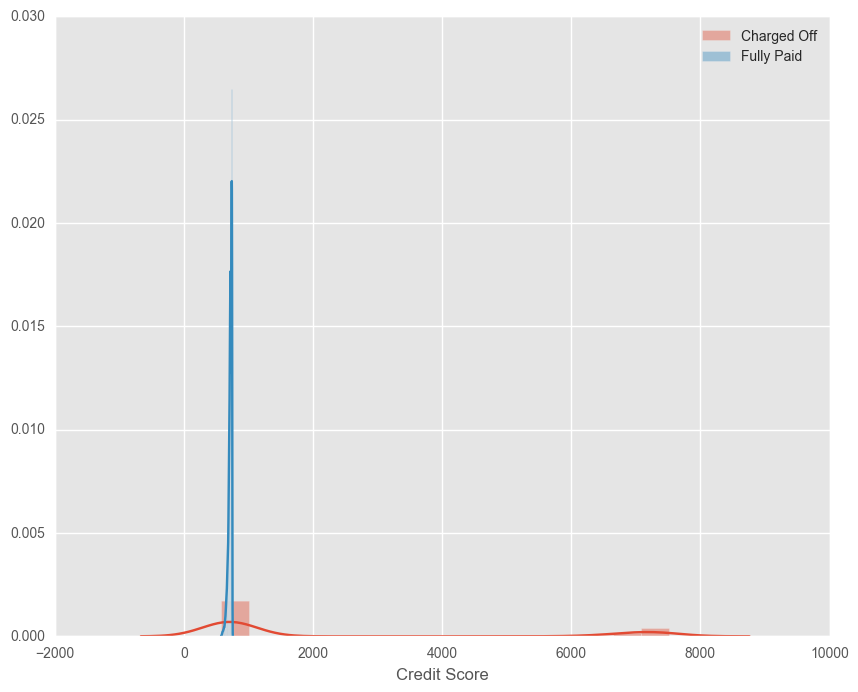

In [5]:
# Veure histograma de Credit Score abans de dividir entre 100.
sns.distplot(df.loc[df['Loan Status']=='Charged Off','Credit Score'].dropna())
sns.distplot(df.loc[df['Loan Status']=='Fully Paid','Credit Score'].dropna())
plt.legend(['Charged Off','Fully Paid'])

In [6]:
# Monthly debt i Max Open Credit haurien de ser nombres

df['Monthly Debt'] = df['Monthly Debt'].astype('str')
df['Monthly Debt'] = df['Monthly Debt'].map(lambda x: x.lstrip('$'))
df['Monthly Debt']= df['Monthly Debt'].astype('float')

# Com a pas previ, netegem els valors de la columna.
df['Maximum Open Credit'] = df['Maximum Open Credit'].str.replace('#VALUE!', '99999999')
# Per a "Credit_Score", "Current_Loan_Amount" i "Anual_Income", el darrer valor duplicat conte 
# la dada correcta, pero per a "Maximum_Open_Credit" el valor correcte es el primer. S'hauria 
# d'actualitzar el valor de "Maximum_Open_Credit" del duplicat amb el valor del primer.
# Primer, creem un diccionari amb valors correctes per a "Maximum_Open_Credit"
Max_Open_Credit_dict = dict()
for index, row in df.iterrows():
    if not row['Loan ID'] in Max_Open_Credit_dict:
        Max_Open_Credit_dict[row['Loan ID']] = row['Maximum Open Credit']
    else:
        pass
# Despres creem una nova columna amb els valors correctes per a tots els duplicats.
# Faltara canviar els valors de la columna "Maximum_Open_Credit" per els de 'Nova' i
# ja podrem eliminar els duplicats quedant-nos amb el segon sense problemes.
df['Nova'] = df['Loan ID'].map(Max_Open_Credit_dict)
# Eliminem la columna "Maximum_Open_Credit" original
df.drop('Maximum Open Credit', axis=1, inplace=True)
# I canviem el nom de "nova" a "Maximum_Open_Credit
df.rename(columns={'Nova': 'Maximum Open Credit'}, inplace=True)
# Finalment, tornem les columnes a l'ordre original.
df = df[['Loan ID', 'Customer ID', 'Loan Status', 'Current Loan Amount',
       'Term', 'Credit Score', 'Years in current job', 'Home Ownership',
       'Annual Income', 'Purpose', 'Monthly Debt',
       'Years of Credit History', 'Months since last delinquent',
       'Number of Open Accounts', 'Number of Credit Problems',
       'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies',
       'Tax Liens']]
df['Maximum Open Credit'] = df['Maximum Open Credit'].astype('float')

# Netegem outliers de credit score dividint per 10
df.loc[df['Credit Score']>800,'Credit Score'] = df.loc[df['Credit Score']>800,'Credit Score']/100

# Convertim els valors extrems de 'Current Loan Amount' a NaN ('9999999' s'esta utilitzant com a codi per a NaN)
df.loc[df['Current Loan Amount'].astype('float')==99999999,'Current Loan Amount']=np.nan

df['Current Credit Balance'] = df['Current Credit Balance'].astype('float64')

# combinem home ownership: 'HaveMortgage' i 'Home Mortgage'
df.loc[df['Home Ownership']=='HaveMortgage','Home Ownership'] = 'Home Mortgage'

# combinem Purpose: 'Other' i 'other'
df.loc[df['Purpose']=='other','Purpose'] = 'Other'

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111107 entries, 0 to 111106
Data columns (total 19 columns):
Loan ID                         111107 non-null object
Customer ID                     111107 non-null object
Loan Status                     111107 non-null object
Current Loan Amount             98369 non-null float64
Term                            111107 non-null object
Credit Score                    89769 non-null float64
Years in current job            111107 non-null object
Home Ownership                  111107 non-null object
Annual Income                   89769 non-null float64
Purpose                         111107 non-null object
Monthly Debt                    111107 non-null float64
Years of Credit History         111107 non-null float64
Months since last delinquent    52104 non-null float64
Number of Open Accounts         111107 non-null int64
Number of Credit Problems       111107 non-null int64
Current Credit Balance          111107 non-null float64
Maximum 

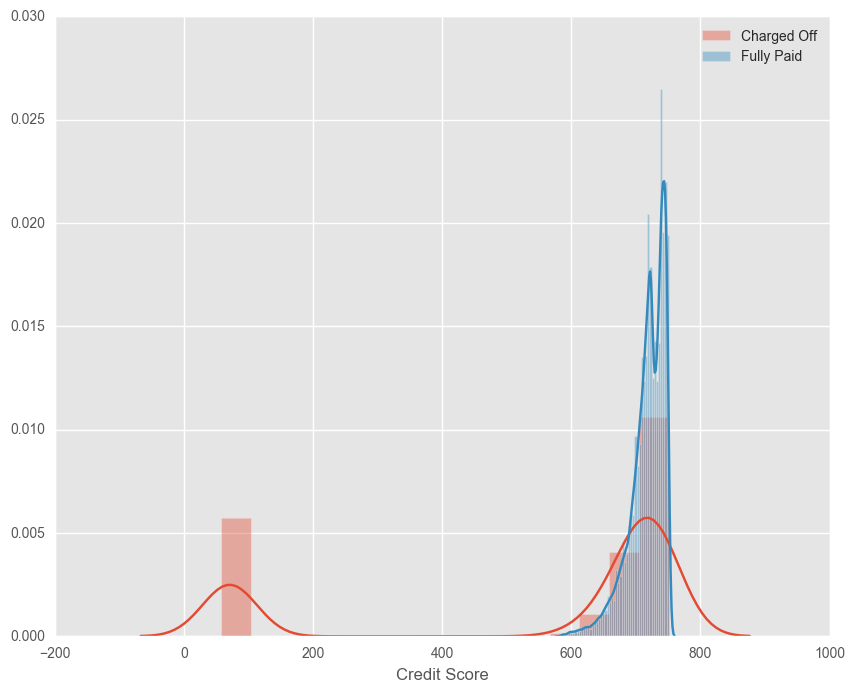

In [7]:
# Veure histograma de Credit Score després de dividir entre 100.
sns.distplot(df.loc[df['Loan Status']=='Charged Off','Credit Score'].dropna())
sns.distplot(df.loc[df['Loan Status']=='Fully Paid','Credit Score'].dropna())
plt.legend(['Charged Off','Fully Paid'])

In [8]:
# Loan IDs repetits
LoanID_counts = df['Loan ID'].value_counts()
print '# of distinct Loan IDs is {}'.format(len(LoanID_counts.index))
repeated_LoanIDs = LoanID_counts[LoanID_counts>1].index
unique_LoanIDs = LoanID_counts[LoanID_counts==1].index
unique_records = df[df['Loan ID'].isin(unique_LoanIDs)]
repeated_records = df[df['Loan ID'].isin(repeated_LoanIDs)]

# Eliminem els repetits i els concatenem amb els "bons"

unique_records = df[df['Loan ID'].isin(unique_LoanIDs)]
repeated_records = df[df['Loan ID'].isin(repeated_LoanIDs)]

def merge_repeated_records(group):
    combined_record={}
    for col in group.columns:
        if (group[col].dtype=='float64'):
            combined_record[col] = group[col].dropna().median()
        elif (group[col].dtype=='int64'):
            l = group[col].values.tolist()
            combined_record[col] = int(max(set(l),key=l.count))
        else:
            l = group[col].values.tolist()
            combined_record[col] = max(set(l),key=l.count)
    return combined_record

cleaned_records = pd.DataFrame(repeated_records.groupby('Loan ID').apply(merge_repeated_records).values.tolist())


processed_df = pd.concat([unique_records,cleaned_records],ignore_index=True)[df.columns]
#processed_df.info()

# dataset complet
x = processed_df.groupby('Loan Status').size()
print 'Length of complete dataset is {}'.format(len(df))
print 'Proportions are as follows: \nCharged off: {}\nFully paid: {}'.format(np.divide(1.0*x,x.sum())[0],np.divide(1.0*x,x.sum())[1])

# omplim Bankrutpcies, Tax Liens, Maximum Open Credit

print processed_df['Bankruptcies'].describe()
processed_df['Bankruptcies']= processed_df['Bankruptcies'].fillna(0)

print '\n'

print processed_df['Tax Liens'].describe()
processed_df['Tax Liens']= processed_df['Tax Liens'].fillna(0)

print '\n'

print processed_df['Maximum Open Credit'].describe()
processed_df['Maximum Open Credit'] = processed_df['Maximum Open Credit'].fillna(np.exp(np.log(1+processed_df['Maximum Open Credit']).mean()))

print '\n'

print processed_df['Months since last delinquent'].describe()
processed_df = processed_df.drop('Months since last delinquent',axis=1)

# Es canvien els valors de "Current Loan Ammount" que en un pas anterior s'han transformat de 99999999 a nan per la mediana
# en funcio del termini del prestec.
d_loan_amount = processed_df[processed_df['Current Loan Amount'].notnull()]
Loan_amount_dict = d_loan_amount.groupby(['Term'])['Current Loan Amount'].median().to_dict()
processed_df.loc[processed_df['Current Loan Amount'].isnull(),'Current Loan Amount']=processed_df.loc[processed_df['Current Loan Amount'].isnull(),'Term'].map(Loan_amount_dict)

# of distinct Loan IDs is 88910
Length of complete dataset is 111107
Proportions are as follows: 
Charged off: 0.283129006861
Fully paid: 0.716870993139
count    88718.000000
mean         0.112672
std          0.343300
min          0.000000
25%               NaN
50%               NaN
75%               NaN
max          7.000000
Name: Bankruptcies, dtype: float64


count    88902.000000
mean         0.028222
std          0.257533
min          0.000000
25%               NaN
50%               NaN
75%               NaN
max         15.000000
Name: Tax Liens, dtype: float64


count    6.553600e+04
mean     3.923377e+04
std      7.038713e+05
min      0.000000e+00
25%               NaN
50%               NaN
75%               NaN
max      1.000000e+08
Name: Maximum Open Credit, dtype: float64


count    40404.000000
mean        35.080289
std         22.008583
min          0.000000
25%               NaN
50%               NaN
75%               NaN
max        176.000000
Name: Months since last deli

In [9]:
pd.to_pickle(processed_df,'data_unique_records')

In [10]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88910 entries, 0 to 88909
Data columns (total 18 columns):
Loan ID                      88910 non-null object
Customer ID                  88910 non-null object
Loan Status                  88910 non-null object
Current Loan Amount          88910 non-null float64
Term                         88910 non-null object
Credit Score                 72821 non-null float64
Years in current job         88910 non-null object
Home Ownership               88910 non-null object
Annual Income                72821 non-null float64
Purpose                      88910 non-null object
Monthly Debt                 88910 non-null float64
Years of Credit History      88910 non-null float64
Number of Open Accounts      88910 non-null int64
Number of Credit Problems    88910 non-null int64
Current Credit Balance       88910 non-null float64
Maximum Open Credit          88910 non-null float64
Bankruptcies                 88910 non-null float64
Tax Liens         

In [11]:
# Years in current job te una categoria, n/a amb una proporcio gran de charge off

def digitize_purpose(purpose):
    if purpose in ['small_business', 'renewable_energy', 'Business Loan']:
        return 1
    elif purpose in ['Medical Bills','Buy House','Debt Consolidation','Home Improvements',
                     'major_purchase', 'moving', 'vacation', 'wedding', 'Take a Trip','other']:
        return 2
    elif purpose in ['Buy a Car', 'Educational Expenses']:
        return 3
    
processed_df['Purpose_combined'] = processed_df['Purpose'].map(digitize_purpose)

processed_df['log_Current Credit Balance'] = np.log(1+processed_df['Current Credit Balance'])

processed_df['log_Maximum Open Credit'] = np.log(1+processed_df['Maximum Open Credit'])

processed_df = processed_df.join(pd.get_dummies(processed_df['Term'],prefix='Term'))
processed_df = processed_df.join(pd.get_dummies(processed_df['Purpose_combined'],prefix='Purpose'))
processed_df = processed_df.join(pd.get_dummies(processed_df['Years in current job']))
processed_df = processed_df.join(pd.get_dummies(processed_df['Home Ownership']))

In [12]:
processed_df.describe()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,...,5 years,6 years,7 years,8 years,9 years,< 1 year,n/a,Home Mortgage,Own Home,Rent
count,88910.000000,72821.000000,7.282100e+04,88910.000000,88910.000000,88910.000000,88910.000000,8.891000e+04,8.891000e+04,88910.000000,...,88910.000000,88910.000000,88910.000000,88910.000000,88910.000000,88910.000000,88910.000000,88910.000000,88910.000000,88910.000000
mean,13695.989911,675.730755,7.240482e+04,963.102059,18.315313,11.110348,0.160477,1.543593e+04,3.419348e+04,0.112428,...,0.068429,0.057305,0.055596,0.046092,0.038938,0.082240,0.042931,0.488584,0.090822,0.420594
std,7987.328392,167.065568,5.771356e+04,637.524064,7.049175,4.978461,0.473746,1.965873e+04,6.043651e+05,0.342969,...,0.252482,0.232426,0.229140,0.209685,0.193449,0.274732,0.202703,0.499872,0.287358,0.493657
min,491.000000,58.500000,4.033000e+03,0.000000,3.600000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8066.000000,NaN,NaN,532.220000,13.500000,8.000000,0.000000,5.949000e+03,1.561800e+04,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11461.500000,NaN,NaN,843.925000,17.000000,10.000000,0.000000,1.103900e+04,2.006154e+04,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18529.000000,NaN,NaN,1250.527500,21.800000,14.000000,0.000000,1.930100e+04,2.995675e+04,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,35875.000000,751.000000,8.713547e+06,22939.120000,70.500000,76.000000,15.000000,1.730472e+06,1.000000e+08,7.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
processed_df.corr()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,...,5 years,6 years,7 years,8 years,9 years,< 1 year,n/a,Home Mortgage,Own Home,Rent
Current Loan Amount,1.000000,-0.075959,0.324244,0.412179,0.141008,0.191745,-0.068337,0.306773,0.011564,-0.094188,...,-0.011711,0.000252,0.008457,0.009732,0.007070,-0.041512,-0.078031,0.178754,-0.021412,-0.168541
Credit Score,-0.075959,1.000000,0.021608,-0.016491,0.030471,-0.012387,-0.011348,-0.000979,-0.009030,-0.004099,...,0.005283,-0.002931,-0.007092,-0.000044,-0.000174,0.002170,-0.013014,0.034724,-0.004770,-0.032374
Annual Income,0.324244,0.021608,1.000000,0.471184,0.154550,0.142911,-0.013520,0.297152,0.023346,-0.046907,...,-0.009315,-0.006402,0.004716,0.004375,0.009905,-0.028590,-0.088704,0.173895,-0.037928,-0.153918
Monthly Debt,0.412179,-0.016491,0.471184,1.000000,0.191442,0.408207,-0.051599,0.473146,0.020249,-0.078828,...,-0.012720,-0.002743,0.007727,0.008053,0.017204,-0.054816,-0.088703,0.203834,-0.036961,-0.184885
Years of Credit History,0.141008,0.030471,0.154550,0.191442,1.000000,0.127471,0.061496,0.204948,0.015989,0.064039,...,-0.050985,-0.036093,-0.025936,-0.011188,-0.006106,-0.068636,0.140401,0.179728,0.031470,-0.200310
Number of Open Accounts,0.191745,-0.012387,0.142911,0.408207,0.127471,1.000000,-0.014123,0.224165,0.011632,-0.025117,...,-0.004665,0.005441,0.002569,0.006301,0.007836,-0.025730,-0.049823,0.132978,-0.009207,-0.129293
Number of Credit Problems,-0.068337,-0.011348,-0.013520,-0.051599,0.061496,-0.014123,1.000000,-0.107929,-0.007373,0.750859,...,-0.011222,-0.004457,0.004431,0.003891,0.005575,-0.023368,0.057211,-0.003235,0.011166,-0.003224
Current Credit Balance,0.306773,-0.000979,0.297152,0.473146,0.204948,0.224165,-0.107929,1.000000,0.065816,-0.119789,...,-0.017990,-0.013611,-0.002361,0.000949,0.009200,-0.031646,-0.028801,0.156721,0.001574,-0.159610
Maximum Open Credit,0.011564,-0.009030,0.023346,0.020249,0.015989,0.011632,-0.007373,0.065816,1.000000,-0.008521,...,-0.000053,-0.003379,-0.002784,-0.001838,-0.002102,0.001863,-0.001362,0.006680,0.003459,-0.008778
Bankruptcies,-0.094188,-0.004099,-0.046907,-0.078828,0.064039,-0.025117,0.750859,-0.119789,-0.008521,1.000000,...,-0.013510,-0.004913,0.004904,0.002232,0.005386,-0.025196,0.062912,-0.006881,0.005836,0.003570


In [14]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88910 entries, 0 to 88909
Data columns (total 41 columns):
Loan ID                       88910 non-null object
Customer ID                   88910 non-null object
Loan Status                   88910 non-null object
Current Loan Amount           88910 non-null float64
Term                          88910 non-null object
Credit Score                  72821 non-null float64
Years in current job          88910 non-null object
Home Ownership                88910 non-null object
Annual Income                 72821 non-null float64
Purpose                       88910 non-null object
Monthly Debt                  88910 non-null float64
Years of Credit History       88910 non-null float64
Number of Open Accounts       88910 non-null int64
Number of Credit Problems     88910 non-null int64
Current Credit Balance        88910 non-null float64
Maximum Open Credit           88910 non-null float64
Bankruptcies                  88910 non-null float64
T

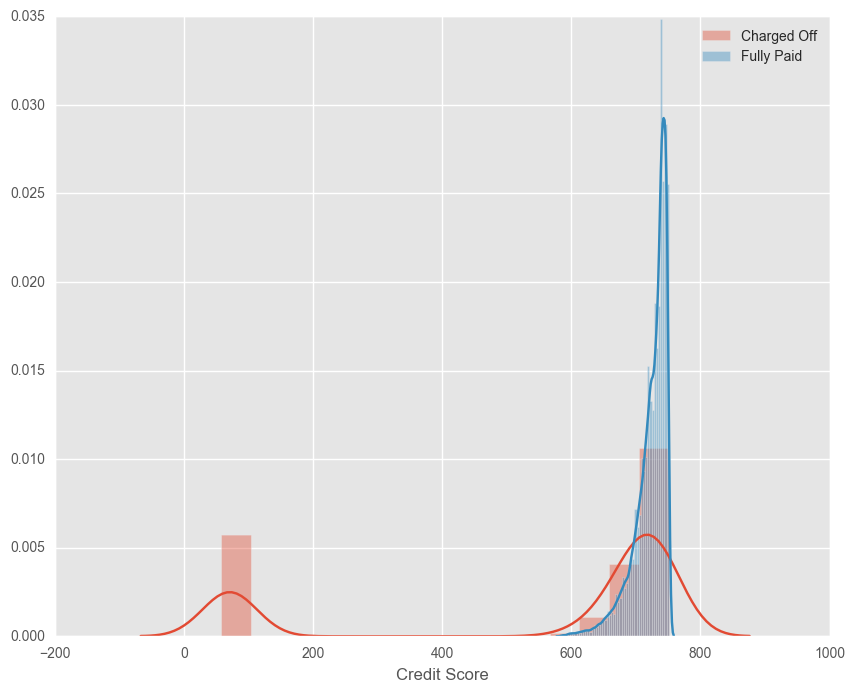

In [15]:
# Veure histograma de Credit Score.
sns.distplot(processed_df.loc[processed_df['Loan Status']=='Charged Off','Credit Score'].dropna())
sns.distplot(processed_df.loc[processed_df['Loan Status']=='Fully Paid','Credit Score'].dropna())
plt.legend(['Charged Off','Fully Paid'])

In [16]:
# Estimar els valors missing de "Credit Score" i "Annual Income" i afegir les featues a "X".
processed_df['Credit Score'] = processed_df['Credit Score'].fillna(processed_df['Credit Score'].mean())
processed_df['Annual Income'] = processed_df['Annual Income'].fillna(processed_df['Annual Income'].mean())

In [31]:
from sklearn.cross_validation import train_test_split

train_df,test_df = train_test_split(processed_df,train_size = 0.75, test_size = 0.25, random_state=7)

# dataset complet
x = processed_df.groupby('Loan Status').size()
print 'Length of complete dataset is {}'.format(len(processed_df))
print 'Proportions are as follows: \nCharged off: {}\nFully paid: {}'.format(np.divide(1.0*x,x.sum())[0],np.divide(1.0*x,x.sum())[1])

# training dataset
x = train_df.groupby('Loan Status').size()
print '\nLength of Training dataset is {}'.format(len(train_df))
print 'Proportions are as follows: \nCharged off: {}\nFully paid: {}'.format(np.divide(1.0*x,x.sum())[0],np.divide(1.0*x,x.sum())[1])

# testing dataset
x = test_df.groupby('Loan Status').size().values
print '\nLength of Testing dataset is {}'.format(len(test_df))
print 'Proportions are as follows: \nCharged off: {}\nFully paid: {}'.format(np.divide(1.0*x,x.sum())[0],np.divide(1.0*x,x.sum())[1])

pd.to_pickle(train_df,'Training_Set_Processed')
pd.to_pickle(test_df,'Testing_Set_Processed')

X = train_df[['Current Loan Amount', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History',
              'Current Credit Balance', 'Maximum Open Credit',
              'Number of Open Accounts','Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 
              'log_Current Credit Balance','log_Maximum Open Credit', 'Term_Long Term', 'Term_Short Term', 
              'Purpose_1.0', 'Purpose_2.0','Purpose_3.0', '1 year', '10+ years', '2 years', '3 years', '4 years', 
              '5 years', '6 years', '7 years', '8 years', '9 years', '< 1 year', 'n/a', 'Home Mortgage', 
              'Own Home', 'Rent']]
Y = train_df['Loan Status'].values

Length of complete dataset is 88910
Proportions are as follows: 
Charged off: 0.283129006861
Fully paid: 0.716870993139

Length of Training dataset is 66682
Proportions are as follows: 
Charged off: 0.282520020395
Fully paid: 0.717479979605

Length of Testing dataset is 22228
Proportions are as follows: 
Charged off: 0.284955911463
Fully paid: 0.715044088537


In [32]:
import pandas
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

X = train_df[['Current Loan Amount', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History',
              'Current Credit Balance', 'Maximum Open Credit',
              'Number of Open Accounts','Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 
              'log_Current Credit Balance','log_Maximum Open Credit', 'Term_Long Term', 'Term_Short Term', 
              'Purpose_1.0', 'Purpose_2.0','Purpose_3.0', '1 year', '10+ years', '2 years', '3 years', '4 years', 
              '5 years', '6 years', '7 years', '8 years', '9 years', '< 1 year', 'n/a', 'Home Mortgage', 
              'Own Home', 'Rent']]
Y = train_df['Loan Status'].values

seed = 7
num_trees = 100
max_features = 3

kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
results = model_selection.cross_val_score(model, X, Y, cv=kfold)

print(results.mean())

0.788878425395


In [33]:
from sklearn.ensemble import RandomForestClassifier as rfr
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':range(10,35,3),'criterion':('gini','entropy'),'max_depth':[2,3,4],'max_features':range(5,12)}
model = rfr(n_estimators=100, max_features=7)
skf_cv = StratifiedKFold(n_splits=10,random_state=7)
clf = GridSearchCV(estimator=model,param_grid=params)

clf.fit(X.values,Y)

clf.best_score_

0.78694400287933775

In [34]:
model.fit(X.values,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=7, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [35]:
# Veure Accuracy
from sklearn.metrics import accuracy_score, f1_score

X_test = test_df[['Current Loan Amount', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History',
                  'Current Credit Balance', 'Maximum Open Credit',
              'Number of Open Accounts','Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 
              'log_Current Credit Balance','log_Maximum Open Credit', 'Term_Long Term', 'Term_Short Term', 
              'Purpose_1.0', 'Purpose_2.0','Purpose_3.0', '1 year', '10+ years', '2 years', '3 years', '4 years', 
              '5 years', '6 years', '7 years', '8 years', '9 years', '< 1 year', 'n/a', 'Home Mortgage', 
              'Own Home', 'Rent']]
Y_test = test_df['Loan Status'].values

y_pred = model.predict(X_test)
print 'Accuracy of the Random Forest Model is {}'.format(accuracy_score(Y_test,y_pred))

Accuracy of the Random Forest Model is 0.786575490373


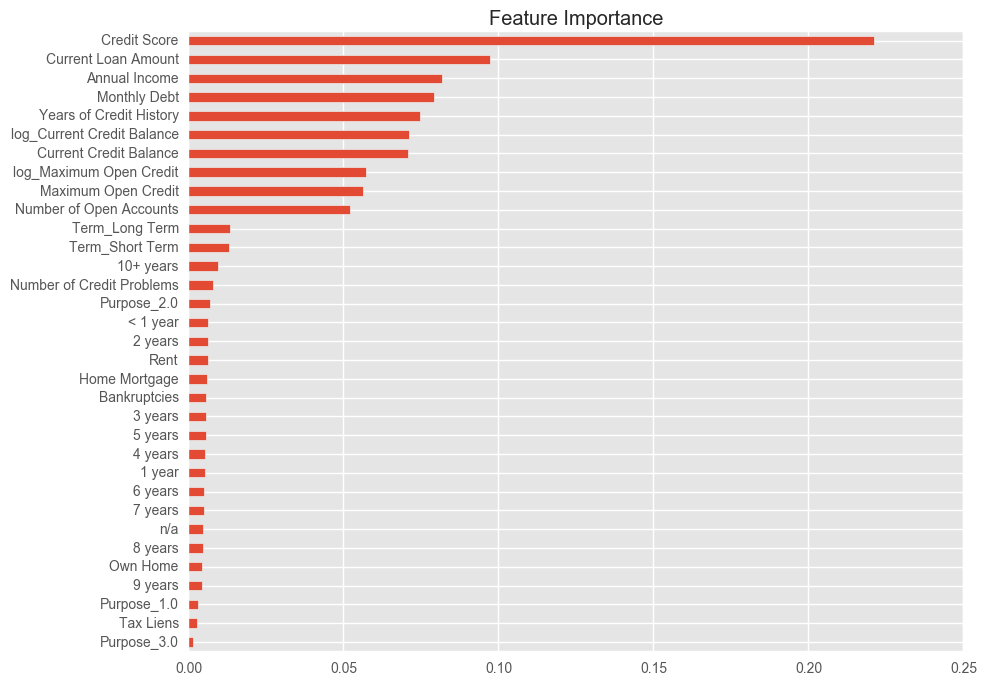

In [36]:
# Analitzar pesos de les variables
s = pd.Series(model.feature_importances_,index = X.columns)
s.sort_values(ascending=True).plot(kind='barh')
plt.title('Feature Importance')

In [17]:
df = combined_df[combined_df['ID']=='train']
df = df.drop(['Loan ID','Customer ID','Credit Score','Annual Income','ID','Term','Years in current job','Purpose','Home Ownership'],axis=1)
#df = df.drop(['Years in current job','Purpose','Home Ownership'],axis=1)
pd.to_pickle(df,'Training_Set_Features')

df = combined_df[combined_df['ID']=='test']
df = df.drop(['Loan ID','Customer ID','Credit Score','Annual Income','ID','Term','Years in current job','Purpose','Home Ownership'],axis=1)
#df = df.drop(['Term','Years in current job','Purpose','Home Ownership'],axis=1)
pd.to_pickle(df,'Testing_Set_Features')